In [2]:
import os
import shutil
import random
from sklearn.model_selection import train_test_split
from collections import defaultdict
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image
import numpy as np
from PIL import Image

# Data loading and splitting

In [3]:
import os
import shutil
import random
from sklearn.model_selection import train_test_split
from collections import defaultdict

# Set random seed for reproducibility
random.seed(42)

# Define paths
base_dir = "."
content_base_dir = os.path.join(base_dir, "Content", "images", "images")
style_dir = os.path.join(base_dir, "style")

# Output directories for splits
content_train_dir = os.path.join(base_dir, "Content", "train")
content_val_dir = os.path.join(base_dir, "Content", "validation")
content_test_dir = os.path.join(base_dir, "Content", "test")
style_train_dir = os.path.join(base_dir, "style", "train")
style_val_dir = os.path.join(base_dir, "style", "validation")
style_test_dir = os.path.join(base_dir, "style", "test")

# Check if split directories already contain images
def check_existing_splits(dirs):
    for directory in dirs:
        if os.path.exists(directory) and len(os.listdir(directory)) > 0:
            return True
    return False

split_dirs = [content_train_dir, content_val_dir, content_test_dir, 
              style_train_dir, style_val_dir, style_test_dir]

if check_existing_splits(split_dirs):
    print("Existing splits found. Skipping sampling and splitting.")
    print("Using images in Content/train/, Content/validation/, Content/test/, style/train/, style/validation/, style/test/.")
else:
    # Check if input directories exist and contain images
    def check_input_directories(content_dir, style_dir):
        if not os.path.exists(content_dir) or not any(os.path.isdir(os.path.join(content_dir, d)) for d in os.listdir(content_dir)):
            raise FileNotFoundError(f"Content directory {content_dir} is missing or empty. Please populate it with images in subfolders (e.g., architecture, art and culture).")
        if not os.path.exists(style_dir) or not any(f.lower().endswith((".jpg", ".jpeg", ".png")) for f in os.listdir(style_dir)):
            raise FileNotFoundError(f"Style directory {style_dir} is missing or empty. Please populate it with style images.")

    # Helper function to get image paths from subfolders
    def get_image_paths(base_directory):
        image_paths = defaultdict(list)
        for category in os.listdir(base_directory):
            category_path = os.path.join(base_directory, category)
            if os.path.isdir(category_path):
                image_paths[category] = [os.path.join(category_path, f) for f in os.listdir(category_path)
                                        if f.lower().endswith((".jpg", ".jpeg", ".png"))]
        return image_paths

    # Check input directories
    check_input_directories(content_base_dir, style_dir)

    # Create output directories if they don't exist
    for directory in [content_train_dir, content_val_dir, content_test_dir, 
                      style_train_dir, style_val_dir, style_test_dir]:
        os.makedirs(directory, exist_ok=True)

    # Load all image paths
    content_images = get_image_paths(content_base_dir)
    style_images = [os.path.join(style_dir, f) for f in os.listdir(style_dir) 
                    if f.lower().endswith((".jpg", ".jpeg", ".png"))]

    # Print initial counts
    total_content = sum(len(images) for images in content_images.values())
    print(f"Total content images: {total_content}")
    print(f"Total style images: {len(style_images)}")

    # Step 1: Sample the datasets
    # Target: 7,000 content images, 3,000 style images
    target_content = 7000
    target_style = 3000

    # Sample content proportionally from each category
    content_sampled = []
    total_images = sum(len(images) for images in content_images.values())
    for category, images in content_images.items():
        if total_images > 0:
            category_target = int((len(images) / total_images) * target_content)
            category_target = min(category_target, len(images))  # Don't exceed available images
            sampled = random.sample(images, category_target) if len(images) >= category_target else images
            content_sampled.extend(sampled)

    # Adjust if still over 7,000 due to rounding
    if len(content_sampled) > target_content:
        content_sampled = random.sample(content_sampled, target_content)
    elif len(content_sampled) < target_content and total_images > len(content_sampled):
        additional = random.sample([img for cat in content_images.values() for img in cat 
                                  if img not in content_sampled], target_content - len(content_sampled))
        content_sampled.extend(additional)

    # Sample style images
    style_sampled = random.sample(style_images, target_style) if len(style_images) >= target_style else style_images

    print(f"Sampled content images: {len(content_sampled)}")
    print(f"Sampled style images: {len(style_sampled)}")

    # Step 2: Split the data (70/15/15)
    # Content split
    content_train, content_temp = train_test_split(content_sampled, train_size=0.7, random_state=42)
    content_val, content_test = train_test_split(content_temp, test_size=0.5, random_state=42)

    # Style split
    style_train, style_temp = train_test_split(style_sampled, train_size=0.7, random_state=42)
    style_val, style_test = train_test_split(style_temp, test_size=0.5, random_state=42)

    print(f"Content split - Train: {len(content_train)}, Val: {len(content_val)}, Test: {len(content_test)}")
    print(f"Style split - Train: {len(style_train)}, Val: {len(style_val)}, Test: {len(style_test)}")

    # Step 3: Move images to respective split directories
    def move_images(image_paths, destination_dir):
        for img_path in image_paths:
            try:
                shutil.move(img_path, os.path.join(destination_dir, os.path.basename(img_path)))
            except Exception as e:
                print(f"Failed to move {img_path}: {e}")

    # Move content images
    move_images(content_train, content_train_dir)
    move_images(content_val, content_val_dir)
    move_images(content_test, content_test_dir)

    # Move style images
    move_images(style_train, style_train_dir)
    move_images(style_val, style_val_dir)
    move_images(style_test, style_test_dir)

    # Step 4: Verify splits before deleting remaining images
    print("Verifying splits before deleting remaining images...")
    print(f"Content train images: {len(os.listdir(content_train_dir))}")
    print(f"Content validation images: {len(os.listdir(content_val_dir))}")
    print(f"Content test images: {len(os.listdir(content_test_dir))}")
    print(f"Style train images: {len(os.listdir(style_train_dir))}")
    print(f"Style validation images: {len(os.listdir(style_val_dir))}")
    print(f"Style test images: {len(os.listdir(style_test_dir))}")

    # Step 5: Delete remaining (unused) images in original folders
    # Reload remaining content images
    remaining_content_images = get_image_paths(content_base_dir)
    remaining_style_images = [os.path.join(style_dir, f) for f in os.listdir(style_dir) 
                             if f.lower().endswith((".jpg", ".jpeg", ".png"))]

    # Delete remaining content images
    print("Deleting remaining content images...")
    for category, images in remaining_content_images.items():
        category_path = os.path.join(content_base_dir, category)
        for img_path in images:
            try:
                os.remove(img_path)
                print(f"Deleted {img_path}")
            except Exception as e:
                print(f"Failed to delete {img_path}: {e}")
        # Remove category folder if empty
        if not os.listdir(category_path):
            shutil.rmtree(category_path)
            print(f"Removed empty category folder: {category_path}")

    # Delete remaining style images
    print("Deleting remaining style images...")
    for img_path in remaining_style_images:
        try:
            os.remove(img_path)
            print(f"Deleted {img_path}")
        except Exception as e:
            print(f"Failed to delete {img_path}: {e}")

# Final verification (always executed)
print("Final folder structure:")
print(f"Content train images: {len(os.listdir(content_train_dir))}")
print(f"Content validation images: {len(os.listdir(content_val_dir))}")
print(f"Content test images: {len(os.listdir(content_test_dir))}")
print(f"Style train images: {len(os.listdir(style_train_dir))}")
print(f"Style validation images: {len(os.listdir(style_val_dir))}")
print(f"Style test images: {len(os.listdir(style_test_dir))}")

Existing splits found. Skipping sampling and splitting.
Using images in Content/train/, Content/validation/, Content/test/, style/train/, style/validation/, style/test/.
Final folder structure:
Content train images: 4876
Content validation images: 1049
Content test images: 1050
Style train images: 2100
Style validation images: 450
Style test images: 450


# Image Preprocessing and Dataset Creation

In [4]:
from torch.utils.data import Dataset
import itertools

# Define image transformations for preprocessing
def get_transforms(img_size=256):
    # Transformations for both content and style images
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return transform

# Custom dataset for neural style transfer
class StyleTransferDataset(Dataset):
    def __init__(self, content_dir, style_dir, transform=None, threshold_values=None, max_samples=None):
        """
        Args:
            content_dir: Directory with content images
            style_dir: Directory with style images
            transform: Optional transform to be applied on images
            threshold_values: List of threshold values for style transfer intensity
            max_samples: Maximum number of content-style pairs to use (None = use all combinations)
        """
        self.content_paths = [os.path.join(content_dir, f) for f in os.listdir(content_dir) 
                             if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        self.style_paths = [os.path.join(style_dir, f) for f in os.listdir(style_dir) 
                           if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        self.transform = transform
        
        # Default threshold values if none provided
        if threshold_values is None:
            # Values between 0.0 (content-focused) and 1.0 (style-focused)
            self.threshold_values = [0.2, 0.4, 0.6, 0.8]
        else:
            self.threshold_values = threshold_values
            
        # Create pairs of content-style indices
        content_indices = range(len(self.content_paths))
        style_indices = range(len(self.style_paths))
        
        # Generate all possible combinations
        all_combinations = list(itertools.product(content_indices, style_indices))
        
        # Sample if max_samples is specified
        if max_samples and max_samples < len(all_combinations):
            # Shuffle and take max_samples
            random.seed(42)  # For reproducibility
            random.shuffle(all_combinations)
            self.combinations = all_combinations[:max_samples]
        else:
            self.combinations = all_combinations
    
    def __len__(self):
        return len(self.combinations)
    
    def __getitem__(self, idx):
        # Get content and style indices from precomputed combinations
        content_idx, style_idx = self.combinations[idx]
        
        # Load content and style images
        content_img = Image.open(self.content_paths[content_idx]).convert('RGB')
        style_img = Image.open(self.style_paths[style_idx]).convert('RGB')
        
        # Apply transformations
        if self.transform:
            content_img = self.transform(content_img)
            style_img = self.transform(style_img)
        
        # Randomly select a threshold value
        threshold = random.choice(self.threshold_values)
        
        # Return a triplet: content image, style image, and threshold
        return {
            'content': content_img, 
            'style': style_img, 
            'threshold': torch.tensor(threshold, dtype=torch.float32),
            'content_path': self.content_paths[content_idx],
            'style_path': self.style_paths[style_idx]
        }

In [5]:
# Create DataLoaders for training, validation, and testing
def create_dataloaders(batch_size=16, num_workers=4, img_size=256, threshold_values=None, 
                      max_train_samples=5000, max_val_samples=1000, max_test_samples=500):
    # Define image transformations
    transform = get_transforms(img_size=img_size)
    
    # Define paths to data directories
    content_train_dir = os.path.join("Content", "train")
    content_val_dir = os.path.join("Content", "validation")
    content_test_dir = os.path.join("Content", "test")
    
    style_train_dir = os.path.join("style", "train")
    style_val_dir = os.path.join("style", "validation")
    style_test_dir = os.path.join("style", "test")
    
    # Create datasets with sample limits
    train_dataset = StyleTransferDataset(content_train_dir, style_train_dir, transform, 
                                        threshold_values, max_samples=max_train_samples)
    val_dataset = StyleTransferDataset(content_val_dir, style_val_dir, transform, 
                                      threshold_values, max_samples=max_val_samples)
    test_dataset = StyleTransferDataset(content_test_dir, style_test_dir, transform, 
                                       threshold_values, max_samples=max_test_samples)
    
    # Print dataset details
    print(f"Train dataset: Using {len(train_dataset)} samples out of {len(os.listdir(content_train_dir)) * len(os.listdir(style_train_dir))} possible combinations")
    print(f"Validation dataset: Using {len(val_dataset)} samples out of {len(os.listdir(content_val_dir)) * len(os.listdir(style_val_dir))} possible combinations")
    print(f"Test dataset: Using {len(test_dataset)} samples out of {len(os.listdir(content_test_dir)) * len(os.listdir(style_test_dir))} possible combinations")
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    return train_loader, val_loader, test_loader

Train dataset: Using 7000 samples out of 10239600 possible combinations
Validation dataset: Using 1000 samples out of 472050 possible combinations
Test dataset: Using 1000 samples out of 472500 possible combinations
Training samples: 7000
Validation samples: 1000
Test samples: 1000

Batch shape for content images: torch.Size([8, 3, 256, 256])
Batch shape for style images: torch.Size([8, 3, 256, 256])
Threshold values: tensor([0.8000, 0.4000, 0.8000, 0.2000, 0.4000, 0.8000, 0.6000, 0.6000])


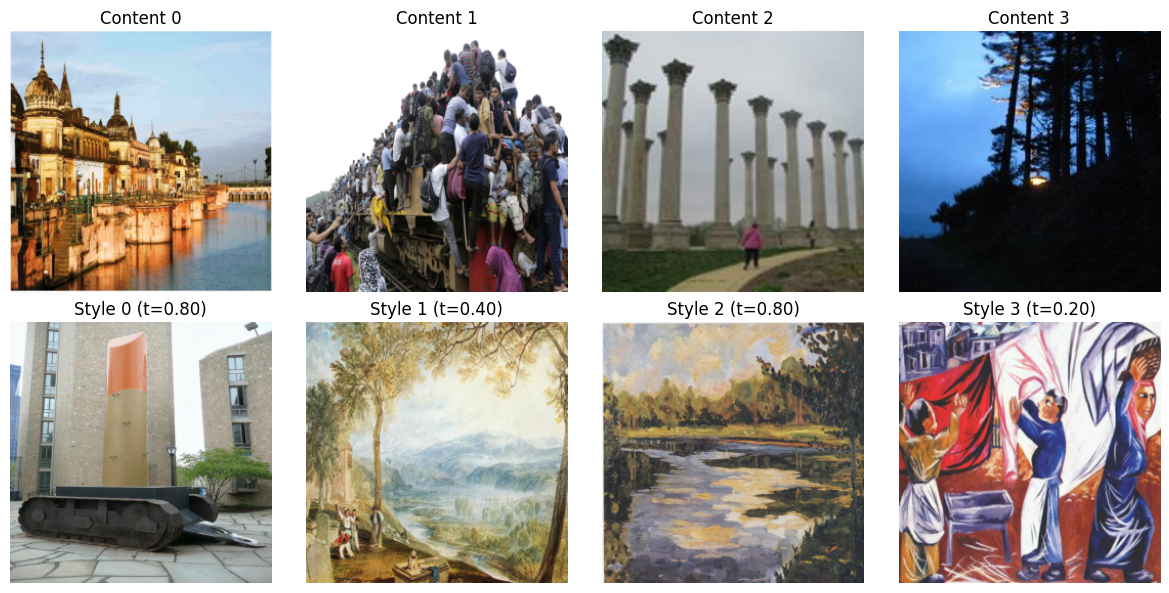

In [6]:
# Verify the dataset and data loaders
# Note: Only run this after data preparation is complete

# Create data loaders with specified batch size and sample limits
batch_size = 8  # Smaller batch size for testing
train_loader, val_loader, test_loader = create_dataloaders(
    batch_size=batch_size, 
    num_workers=0,
    max_train_samples=7000,  # Limit train samples to 5000
    max_val_samples=1000,    # Limit validation samples to 1000
    max_test_samples=1000     # Limit test samples to 500
)

# Print dataset sizes
print(f"Training samples: {len(train_loader.dataset)}")
print(f"Validation samples: {len(val_loader.dataset)}")
print(f"Test samples: {len(test_loader.dataset)}")

# Check a single batch
sample_batch = next(iter(train_loader))
print(f"\nBatch shape for content images: {sample_batch['content'].shape}")
print(f"Batch shape for style images: {sample_batch['style'].shape}")
print(f"Threshold values: {sample_batch['threshold']}")

# Function to denormalize and display images
def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
    return tensor * std + mean

# Display first few images in the batch (optional - uncomment to visualize)
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
for i in range(min(4, batch_size)):
#     # Display content image
     plt.subplot(2, 4, i + 1)
     img = denormalize(sample_batch['content'][i:i+1]).squeeze(0).permute(1, 2, 0).numpy()
     img = np.clip(img, 0, 1)
     plt.imshow(img)
     plt.title(f"Content {i}")
     plt.axis('off')
     
#     # Display style image
     plt.subplot(2, 4, i + 5)
     img = denormalize(sample_batch['style'][i:i+1]).squeeze(0).permute(1, 2, 0).numpy()
     img = np.clip(img, 0, 1)
     plt.imshow(img)
     plt.title(f"Style {i} (t={sample_batch['threshold'][i]:.2f})")
     plt.axis('off')
 
plt.tight_layout()
plt.show()

# Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid
import os

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom VGG model for style transfer
class VGGStyleTransfer(nn.Module):
    def __init__(self, fine_tune=False):
        super(VGGStyleTransfer, self).__init__()
        vgg = models.vgg19(weights='DEFAULT').features.eval().to(device)
        
        self.content_layers = ['conv4_2']
        self.style_layers = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']
        
        self.layer_names = {
            'conv1_1': 0, 'conv1_2': 2,
            'conv2_1': 5, 'conv2_2': 7,
            'conv3_1': 10, 'conv3_2': 12, 'conv3_3': 14, 'conv3_4': 16,
            'conv4_1': 19, 'conv4_2': 21, 'conv4_3': 23, 'conv4_4': 25,
            'conv5_1': 28, 'conv5_2': 30, 'conv5_3': 32, 'conv5_4': 34
        }
        
        max_index = max(self.layer_names.values())
        self.model = nn.Sequential()
        for i, layer in enumerate(vgg):
            if i <= max_index:
                self.model.add_module(str(i), layer)
        
        # Fine-tune specific layers
        if fine_tune:
            for name, param in self.model.named_parameters():
                if '19' in name or '21' in name:  # conv4_1, conv4_2
                    param.requires_grad = True
                else:
                    param.requires_grad = False
        else:
            for param in self.model.parameters():
                param.requires_grad = False
    
    def forward(self, x):
        content_features = {}
        style_features = {}
        for name, layer in self.model.named_children():
            x = layer(x)
            layer_idx = int(name)
            for layer_name, idx in self.layer_names.items():
                if idx == layer_idx:
                    if layer_name in self.content_layers:
                        content_features[layer_name] = x.clone()
                    if layer_name in self.style_layers:
                        style_features[layer_name] = x.clone()
        return content_features, style_features

# Gram matrix with normalization
def gram_matrix(feature):
    batch_size, channels, height, width = feature.size()
    feature = feature / (feature.std() + 1e-8)
    feature = feature.view(batch_size * channels, height * width)
    gram = torch.mm(feature, feature.t())
    return gram.div(batch_size * channels * height * width)

# Loss functions
class StyleTransferLoss:
    def __init__(self, content_layers, style_layers):
        self.content_layers = content_layers
        self.style_layers = style_layers
    
    def compute_loss(self, content_features, style_features, generated_features, threshold):
        content_loss = 0
        for layer in self.content_layers:
            content_loss += nn.functional.mse_loss(
                generated_features[0][layer], content_features[layer]
            )
        
        style_loss = 0
        for layer in self.style_layers:
            gen_gram = gram_matrix(generated_features[1][layer])
            style_gram = gram_matrix(style_features[layer])
            style_loss += nn.functional.mse_loss(gen_gram, style_gram)
        
        # Dynamic threshold weighting
        content_weight = max(0.1, (1.0 - threshold) ** 2)
        style_weight = threshold ** 2
        content_scale = 1e5 if threshold < 0.5 else 2e5
        style_scale = 1e9 if threshold < 0.5 else 5e8
        content_loss *= content_weight * content_scale
        style_loss *= style_weight * style_scale
        
        # Total variation loss
        tv_loss = (
            torch.sum(torch.abs(generated_features[2][:, :, :, :-1] - generated_features[2][:, :, :, 1:])) +
            torch.sum(torch.abs(generated_features[2][:, :, :-1, :] - generated_features[2][:, :, 1:, :]))
        ) * 2e2
        
        # L2 regularization
        l2_reg = torch.norm(generated_features[2], p=2) * 1e-3
        total_loss = content_loss + style_loss + tv_loss + l2_reg
        return total_loss, content_loss, style_loss, tv_loss



In [ ]:
# Training function (no image outputs)
def train_style_transfer(model, train_loader, num_iterations=1000, output_dir="stylized_outputs"):
    os.makedirs(output_dir, exist_ok=True)
    loss_criterion = StyleTransferLoss(model.content_layers, model.style_layers)
    
    for batch_idx, batch in enumerate(train_loader):
        try:
            content_img = batch['content'].to(device)
            style_img = batch['style'].to(device)
            threshold = batch['threshold'].to(device)
            if torch.isnan(content_img).any() or torch.isnan(style_img).any():
                print(f"Skipping batch {batch_idx+1}: Invalid input images")
                continue
            
            generated_img = content_img.clone().requires_grad_(True).to(device)
            
            optimizer = optim.Adam([
                {'params': generated_img, 'lr': 0.01},
                {'params': [p for p in model.parameters() if p.requires_grad], 'lr': 1e-5}
            ])
            
            content_norm = 1.0
            style_norm = 1.0
            for iteration in range(num_iterations):
                optimizer.zero_grad()
                with torch.no_grad():
                    generated_img.clamp_(0, 1)
                
                # Compute features each iteration
                content_features, _ = model(content_img)
                _, style_features = model(style_img)
                gen_features = model(generated_img)
                gen_features = (gen_features[0], gen_features[1], generated_img)
                
                total_loss, content_loss, style_loss, tv_loss = loss_criterion.compute_loss(
                    content_features, style_features, gen_features, threshold[0]
                )
                
                if torch.isnan(total_loss):
                    print(f"Batch {batch_idx+1}, Iteration {iteration}: NaN detected, skipping")
                    break
                
                total_loss.backward()
                torch.nn.utils.clip_grad_norm_([generated_img] + [p for p in model.parameters() if p.requires_grad], max_norm=1.0)
                optimizer.step()
                
                if iteration == 0:
                    content_norm = 1.0 / (content_loss.item() + 1e-8)
                    style_norm = 1.0 / (style_loss.item() + 1e-8)
                
                if iteration % 100 == 0:
                    print(f"Batch {batch_idx+1}, Iteration {iteration}, Threshold={threshold[0]:.2f}, "
                          f"Content={batch['content_path'][0]}, Style={batch['style_path'][0]}: "
                          f"Total Loss: {total_loss.item():.2f}, "
                          f"Content Loss: {content_loss.item():.2f}, "
                          f"Style Loss: {style_loss.item():.2f}, "
                          f"TV Loss: {tv_loss.item():.2f}")
            
            print(f"Completed training for batch {batch_idx+1}")
        
        except Exception as e:
            print(f"Failed to process batch {batch_idx+1}: {e}")
            continue

# Evaluation function (with image outputs for test)
def evaluate(model, loader, output_dir="eval_outputs", num_iterations=200, max_output_images=5):
    os.makedirs(output_dir, exist_ok=True)
    loss_criterion = StyleTransferLoss(model.content_layers, model.style_layers)
    total_losses, content_losses, style_losses, tv_losses = [], [], [], []
    output_count = 0
    
    for batch_idx, batch in enumerate(loader):
        try:
            content_img = batch['content'].to(device)
            style_img = batch['style'].to(device)
            threshold = batch['threshold'].to(device)
            generated_img = content_img.clone().requires_grad_(True).to(device)
            
            optimizer = optim.Adam([generated_img], lr=0.01)
            
            for _ in range(num_iterations):
                optimizer.zero_grad()
                with torch.no_grad():
                    generated_img.clamp_(0, 1)
                content_features, _ = model(content_img)
                _, style_features = model(style_img)
                gen_features = model(generated_img)
                gen_features = (gen_features[0], gen_features[1], generated_img)
                total_loss, content_loss, style_loss, tv_loss = loss_criterion.compute_loss(
                    content_features, style_features, gen_features, threshold[0]
                )
                total_loss.backward()
                torch.nn.utils.clip_grad_norm_([generated_img], max_norm=1.0)
                optimizer.step()
            
            total_losses.append(total_loss.item())
            content_losses.append(content_loss.item())
            style_losses.append(style_loss.item())
            tv_losses.append(tv_loss.item())
            
            # Save images for up to max_output_images batches
            if output_count < max_output_images:
                with torch.no_grad():
                    generated_img.clamp_(0, 1)
                    save_image(content_img, os.path.join(output_dir, f"content_eval_{batch_idx+1}.png"))
                    save_image(style_img, os.path.join(output_dir, f"style_eval_{batch_idx+1}.png"))
                    save_image(generated_img, os.path.join(output_dir, f"stylized_eval_{batch_idx+1}.png"))
                    composite = make_grid([content_img[0], style_img[0], generated_img[0]], nrow=3, padding=5)
                    save_image(composite, os.path.join(output_dir, f"composite_eval_{batch_idx+1}.png"))
                
                print(f"Saved eval images for batch {batch_idx+1} (Threshold={threshold[0]:.2f})")
                output_count += 1
            
        except Exception as e:
            print(f"Eval batch {batch_idx+1} failed: {e}")
            continue
    
    avg_total = sum(total_losses) / len(total_losses) if total_losses else 0
    avg_content = sum(content_losses) / len(content_losses) if content_losses else 0
    avg_style = sum(style_losses) / len(style_losses) if style_losses else 0
    avg_tv = sum(tv_losses) / len(tv_losses) if tv_losses else 0
    print(f"Average Losses: Total={avg_total:.2f}, Content={avg_content:.2f}, Style={avg_style:.2f}, TV={avg_tv:.2f}")
    return avg_total, avg_content, avg_style, avg_tv

# Example usage
if __name__ == "__main__":
    from model import create_dataloaders
    
    # Create DataLoaders with larger dataset
    train_loader, val_loader, test_loader = create_dataloaders(
        batch_size=1,
        num_workers=0,
        max_train_samples=100,  # Increased from 10
        max_val_samples=200,   # Increased from 50
        max_test_samples=200   # Increased from 50
    )
    
    # Initialize and fine-tune model
    model = VGGStyleTransfer(fine_tune=True).to(device)
    
    # Train
    print("Training...")
    train_style_transfer(model, train_loader, num_iterations=1000)
    
    # Evaluate
    print("Validation Results:")
    evaluate(model, val_loader, "val_outputs", num_iterations=200, max_output_images=5)
    print("Test Results:")
    evaluate(model, test_loader, "test_outputs", num_iterations=200, max_output_images=5)

Train dataset: Using 10 samples out of 10239600 possible combinations
Validation dataset: Using 1000 samples out of 472050 possible combinations
Test dataset: Using 500 samples out of 472500 possible combinations
Batch 1, Iteration 0, Threshold=0.80, Content=Content\train\11453211054_63b80ff7e6_m.jpg, Style=style\train\vincent-van-gogh_interior-with-peasant-woman-sewing-1885-3.jpg: Total Loss: 3087814.75, Content Loss: 930046.69, Style Loss: 930046.69, TV Loss: 2132048.50
Batch 1, Iteration 100, Threshold=0.80, Content=Content\train\11453211054_63b80ff7e6_m.jpg, Style=style\train\vincent-van-gogh_interior-with-peasant-woman-sewing-1885-3.jpg: Total Loss: 1308426.62, Content Loss: 379761.34, Style Loss: 379761.34, TV Loss: 888072.56
Batch 1, Iteration 200, Threshold=0.80, Content=Content\train\11453211054_63b80ff7e6_m.jpg, Style=style\train\vincent-van-gogh_interior-with-peasant-woman-sewing-1885-3.jpg: Total Loss: 1097357.38, Content Loss: 380527.81, Style Loss: 380527.81, TV Loss: 672